#Import Library

In [ ]:
#For Importing Data from Drive
from google.colab import drive
drive.mount('/content/drive')


#For Data Processing
import pandas as pd
import numpy as np


#For Visualization
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


# For Text Processing
!pip install emoji
!pip install TextBlob
!pip install transformers
!pip install pyLDAvis
!pip install sentencepiece
!pip install Sastrawi
!pip install googletrans==3.1.0a0
!pip install deep-translator

import emoji
import tweepy
import string
import re
import gensim
import nltk
import multiprocessing
import configparser

from textblob import TextBlob
from transformers import pipeline
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from googletrans import Translator
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.models import Phrases

import gensim.corpora as corpora
import pyLDAvis.gensim_models;pyLDAvis.enable_notebook()
from gensim import corpora, models

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from huggingface_hub import notebook_login
from pprint import pprint


#For Clustering
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Mounted at /content/drive


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 4.7 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=5a4a89e80586d28f664a9426b235d9fa1395460030a7ee076377738b96d48cd4
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 36.9 MB/s 
     |████████████████████████████████| 120 kB 57.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... 

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`



#Collecting Data Set

##Collecting using Tweepy

Data that is collected from twitter is stored in csv file. the data we collected are tweets that is 
*   In the Period of : 15 July - 22 July
*   Containing : [ 'mobil listrik', 'motor listrik', 'kendaraan listrik', 'sepeda listrik', 'electric vechicle' ]



In [ ]:
# #Write down the Key
# api_key = 'YOUR_API_KEY'
# api_key_secret = 'YOUR_API_KEY_SECRET'

# access_token = 'YOUR_ACCESS_TOKEN'
# access_token_secret = 'YOUR_ACCESS_TOKEN_SECRET'

# #authentication
# auth = tweepy.OAuthHandler(api_key, api_key_secret)
# auth.set_access_token(access_token, access_token_secret)
# api = tweepy.API(auth)

# #for search specific keyword/hashtag
# keyword = 'motor listrik'
# limit = 10000
# start_date = '2022-07-15'
# end_date = '2022-07-22'

# search_tweets = tweepy.Cursor(api.search, q=keyword, lang = "id",
#                               since=start_date, until=end_date,
#                               count=100, tweet_mode='extended').items(limit)
# data = []
# columns = ['Time', 'User', 'Tweet', 'is_verified_acc']
# for tweet in search_tweets :
#   data.append([tweet.created_at, tweet.user.screen_name, tweet.full_text, tweet.user.verified])

# df = pd.DataFrame(data, columns = columns)

# to simplify later analysis, save dataframes to local
# df.to_csv('dataset_all.csv')

# Data Cleaning

In [ ]:
def find_emoji(text) :
    
    # Change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # Delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    
    return text

def encode_emoji(dataset, var) :
    
    df = dataset.copy().reset_index()
    
    # Get index for rows with emoji
    list_idx = []
    for idx, review in enumerate(df[var]):
        if any(char in emoji.EMOJI_DATA for char in review):
            list_idx.append(idx)
            
    print('Percentage of dataset with emoji :',len(list_idx)/len(df)*100)
            
    # Encode emoji
    df.loc[list_idx, var] = df.loc[list_idx, var].apply(find_emoji)
    
    return df

def remove_stop_words(text) :
    
    # List of stop words
    id_stop_words = stopwords.words('indonesian')
    en_stop_words = stopwords.words('english')
    id_stop_words.extend(['gan','kak','pak','hai','ka','yg','nya',
                   'ya','mas','gk','bro','halo','aja','nih','sis',
                   'kan','om','kk','tp','ni','utk','nggak','mba','mbak',
                   'yah','min','bos','ny','yaa','juragan','kakak',
                  'oke','admin','sist','selamat_pagi',
                   'selamat_sore','boss','hallo','hello','helo','kang',
                   'selamat_malam','bang','sih',
                   'selamat_siang','sore','pagi','malam','siang','kalo', 'kalau',
                    'dr', 'dari', 'dri', 'jg', 'juga'
                   ,'jd', 'jadi', 'org', 'b', 'cc'
                   ])
    
    # Remove stop words
    text = ' '.join([c for c in text.split() if c not in id_stop_words])    
    text = ' '.join([c for c in text.split() if c not in en_stop_words])    
    
    return text

def preprocess_text(tweet) :
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) #remove hyperlink
    tweet = re.sub(r"#", "", tweet) #remove hashtags
    tweet = re.sub(r'^RT[\s]+', '', tweet) #remove RT
    tweet = tweet.replace('\n'," ")
    tweet = tweet.replace('"'," ")
    tweet = re.sub(r"[_,-.;:@#()?.!&$+]+\ *", " ", tweet)
    tweet = re.sub(r'\$\w*', '', tweet) #remove stock market tickers like $GE
    tweet = re.sub(r'[0-9]+', '', tweet)
    tweet = tweet.lower() #make all lower case
    tweet = remove_stop_words(tweet)
    tweet = " ".join(tweet.split())    
    return tweet

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemming process using sastrawi
def preprocess_stemming(tweet) :
    tweet = stemmer.stem(tweet)
    return tweet

df['clean_text'] = df['Tweet']

df = encode_emoji(df, 'clean_text')
df['clean_text'] = df['clean_text'].apply(preprocess_text)
df['clean_text'] = df['clean_text'].apply(preprocess_stemming)

In [ ]:
df.dropna(inplace = True)
df.shape

# Exploratory Data Analysis

In [ ]:
df_cleaned = df.copy()
df_cleaned['clean_text'] = df_cleaned['clean_text'].astype(str)

## Tweet Length Distribution

In [ ]:
df_cleaned['length'] = df_cleaned.apply(lambda x : len(x['clean_text'].split()), axis=1)
# df_clean_1['length'] = df_clean_1.apply(lambda x : len(x['Tweet'].split()), axis=1)

In [ ]:
plt.figure(figsize = (15,8))
sns.distplot(df_clean['length'], label = 'With Main Words');
# sns.distplot(df_clean_1['length'], label = 'Without Main Words');
plt.legend()
plt.xticks(np.arange(0,50,1))

NameError: ignored

<Figure size 1080x576 with 0 Axes>

## Most Mention Keyword

### Tweet in General

In [ ]:
df_cleaned.head()

,index,Time,User,Tweet,is_verified_acc,clean_text,length
0,0,2022-07-21T23:45:16Z,nusakininews,Komitmen Konversi Seribu Sepeda Motor Penggera...,False,komitmen konversi ribu sepeda motor gerak bbm ...,10
1,1,2022-07-21T23:39:48Z,petrominer_com,Kementerian ESDM telah bekerjasama dengan beng...,False,menteri esdm bekerjasama bengkel bengkel usaha...,18
2,2,2022-07-21T23:39:19Z,prismono,Kementerian ESDM telah bekerjasama dengan beng...,False,menteri esdm bekerjasama bengkel bengkel usaha...,18
3,3,2022-07-21T23:10:22Z,iniayybeneran,Aaaa. Doi ngajak jalan. Tapi kata dia rahasia ...,False,aaaa doi ngajak jalan rahasia wkwkwk nnya mana...,25
4,4,2022-07-21T18:27:09Z,icedcaffemisto,"sebagai pecinta ""sepeda cewek"", aku seneng ban...",False,cinta sepeda cewek neng banget sepeda listrik ...,22


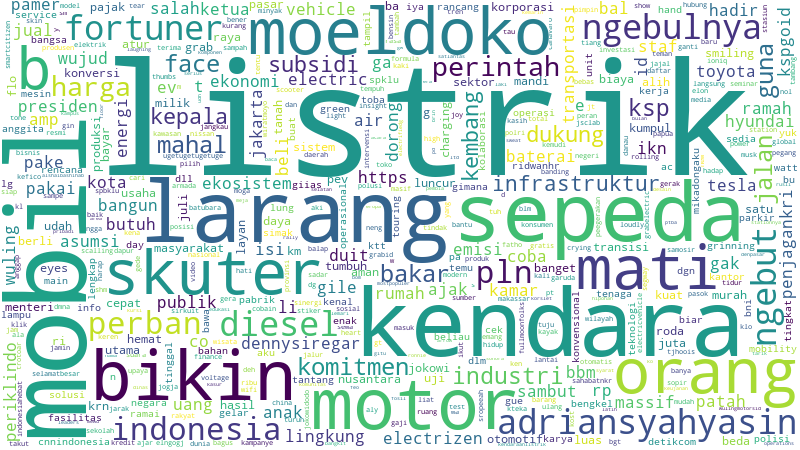

In [ ]:
#Tweet Joined
datacloud = df_cleaned.clean_text.values.tolist()
datacloud = ' '.join(datacloud)

#Word Cloud
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue'
                      ,width=800, height=450, collocations=False).generate_from_text("".join(datacloud))
wordcloud.to_image()

### Tweet excluding the word used in Extracting Data

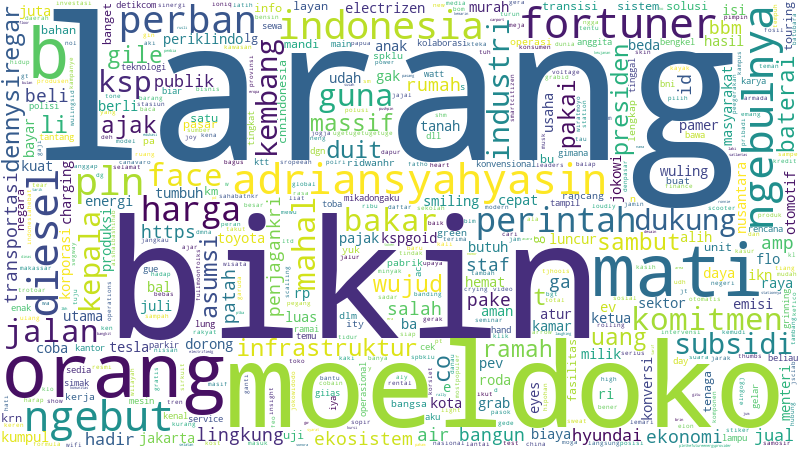

In [ ]:
datacloud_2 = re.sub(r"kendara|listrik|kendaraan|elektrik|electric|vehicle|mobil|motor|skuter|sepeda", "", datacloud)

#Word Cloud
wordcloud_2 = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue'
                      ,width=800, height=450, collocations=False).generate_from_text("".join(datacloud_2))
wordcloud_2.to_image()

In [ ]:
#sort and count word
import operator
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

d = word_count(datacloud_2)
sorted_d = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True))

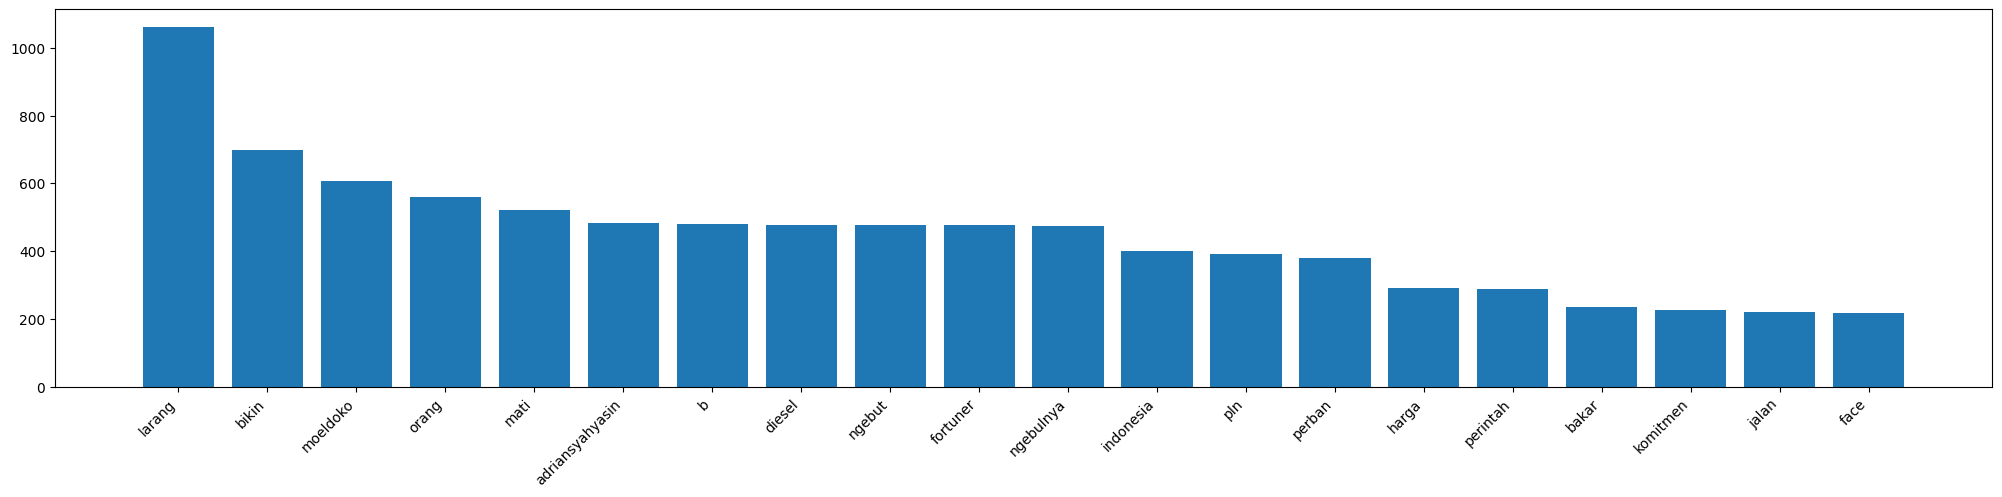

In [ ]:
#Top word after removing stop words
top_word = sorted_d.copy()
top_word = {k: top_word[k] for k in list(top_word)[:20]}

fig = plt.figure(figsize=(25,5),dpi=100)
ax = fig.add_subplot(111)
bar = ax.bar(range(len(top_word)), list(top_word.values()), align='center')
plt.xticks(range(len(top_word)), list(top_word.keys()))
plt.xticks(rotation=45, ha='right')
plt.savefig('top_word.png')
plt.show()

## Most Popular User

### General

In [ ]:
df_cleaned.User

0          nusakininews
1        petrominer_com
2              prismono
3         iniayybeneran
4        icedcaffemisto
             ...       
3978          doysaurus
3979          bannednab
3980    pln_sulselrabar
3981    pln_sulselrabar
3982          ide2nesia
Name: User, Length: 3983, dtype: object

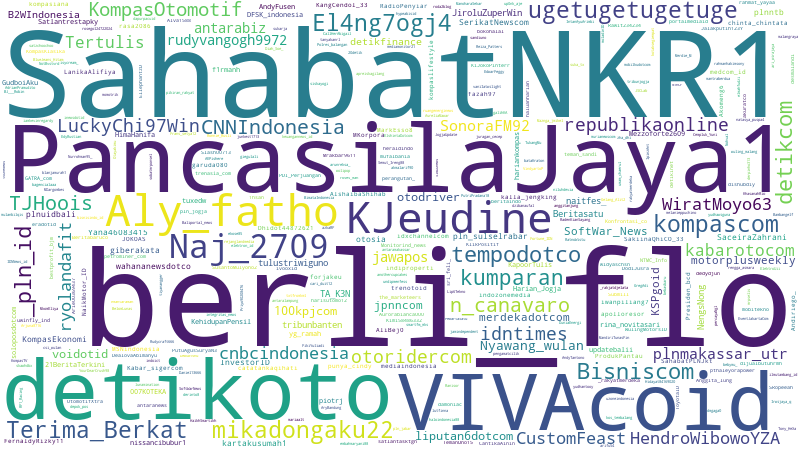

In [ ]:
#User Data Joined
userdata = df_cleaned.User.values.tolist()
userdata = ' '.join(userdata)

#User Cloud
usercloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue'
                      ,width=800, height=450, collocations=False).generate_from_text("".join(userdata))
usercloud.to_image()

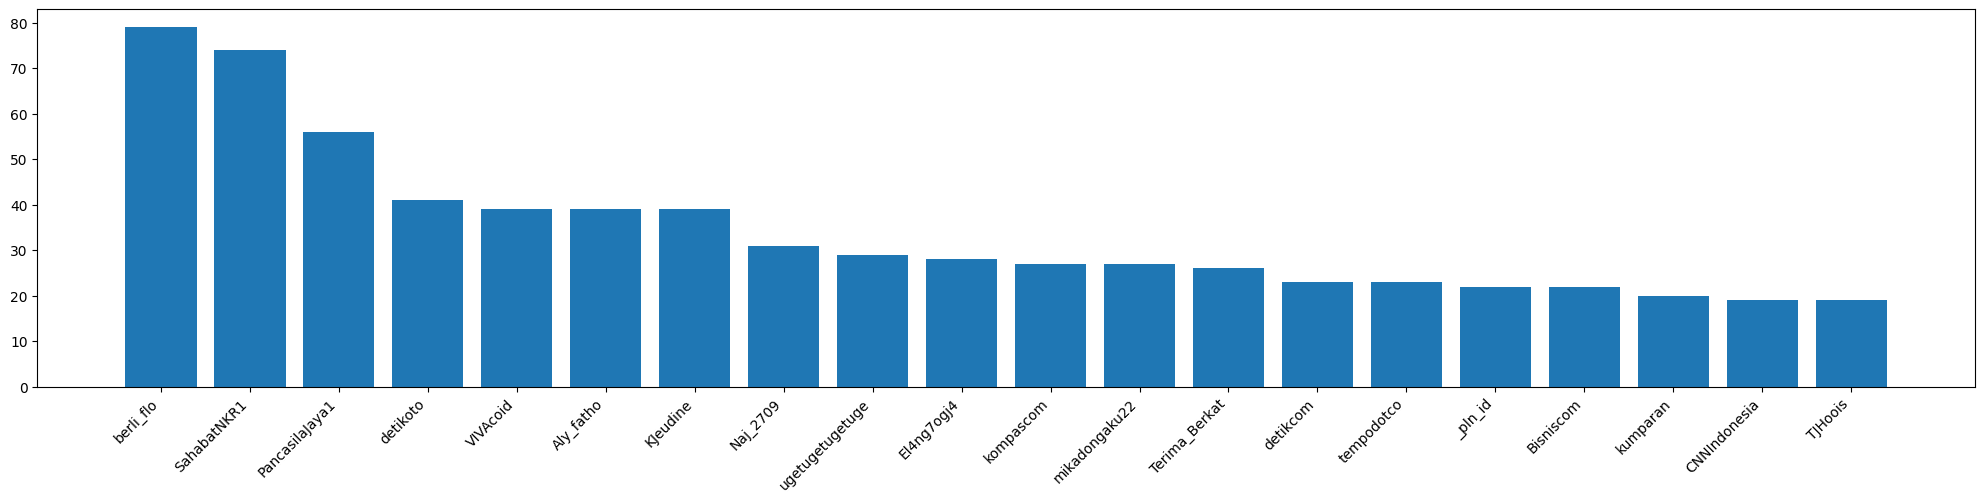

In [ ]:
#Top User
d = word_count(userdata)
sorted_d = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True))

top_user = sorted_d.copy()
top_user = {k: top_user[k] for k in list(top_user)[:20]}

fig = plt.figure(figsize=(25,5),dpi=100)
ax = fig.add_subplot(111)
bar = ax.bar(range(len(top_user)), list(top_user.values()), align='center')
plt.xticks(range(len(top_user)), list(top_user.keys()))
plt.xticks(rotation=45, ha='right')
plt.savefig('top_user.png')
plt.show()

### User that is not from verified acc

In [ ]:
df_cleaned.head()

,index,Time,User,Tweet,is_verified_acc,clean_text,length
0,0,2022-07-21T23:45:16Z,nusakininews,Komitmen Konversi Seribu Sepeda Motor Penggera...,False,komitmen konversi ribu sepeda motor gerak bbm ...,10
1,1,2022-07-21T23:39:48Z,petrominer_com,Kementerian ESDM telah bekerjasama dengan beng...,False,menteri esdm bekerjasama bengkel bengkel usaha...,18
2,2,2022-07-21T23:39:19Z,prismono,Kementerian ESDM telah bekerjasama dengan beng...,False,menteri esdm bekerjasama bengkel bengkel usaha...,18
3,3,2022-07-21T23:10:22Z,iniayybeneran,Aaaa. Doi ngajak jalan. Tapi kata dia rahasia ...,False,aaaa doi ngajak jalan rahasia wkwkwk nnya mana...,25
4,4,2022-07-21T18:27:09Z,icedcaffemisto,"sebagai pecinta ""sepeda cewek"", aku seneng ban...",False,cinta sepeda cewek neng banget sepeda listrik ...,22


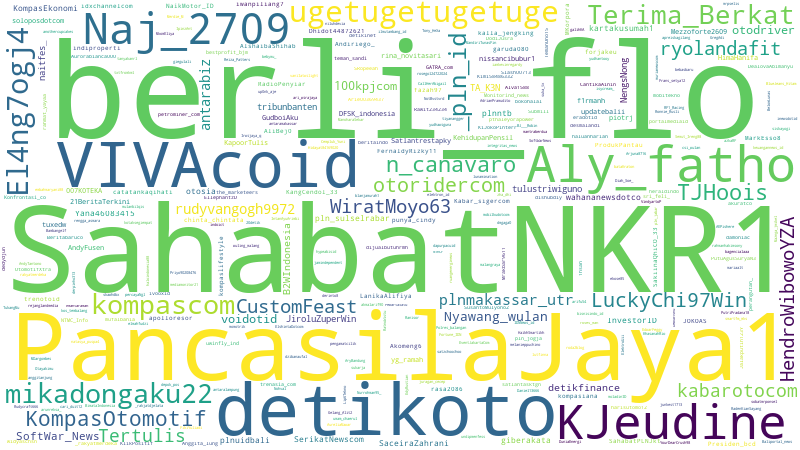

In [ ]:
#User Data Joined
userdata = df_cleaned[df_cleaned['is_verified_acc'] == False].User.values.tolist()
userdata = ' '.join(userdata)

#User Cloud
usercloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue'
                      ,width=800, height=450, collocations=False).generate_from_text("".join(userdata))
usercloud.to_image()

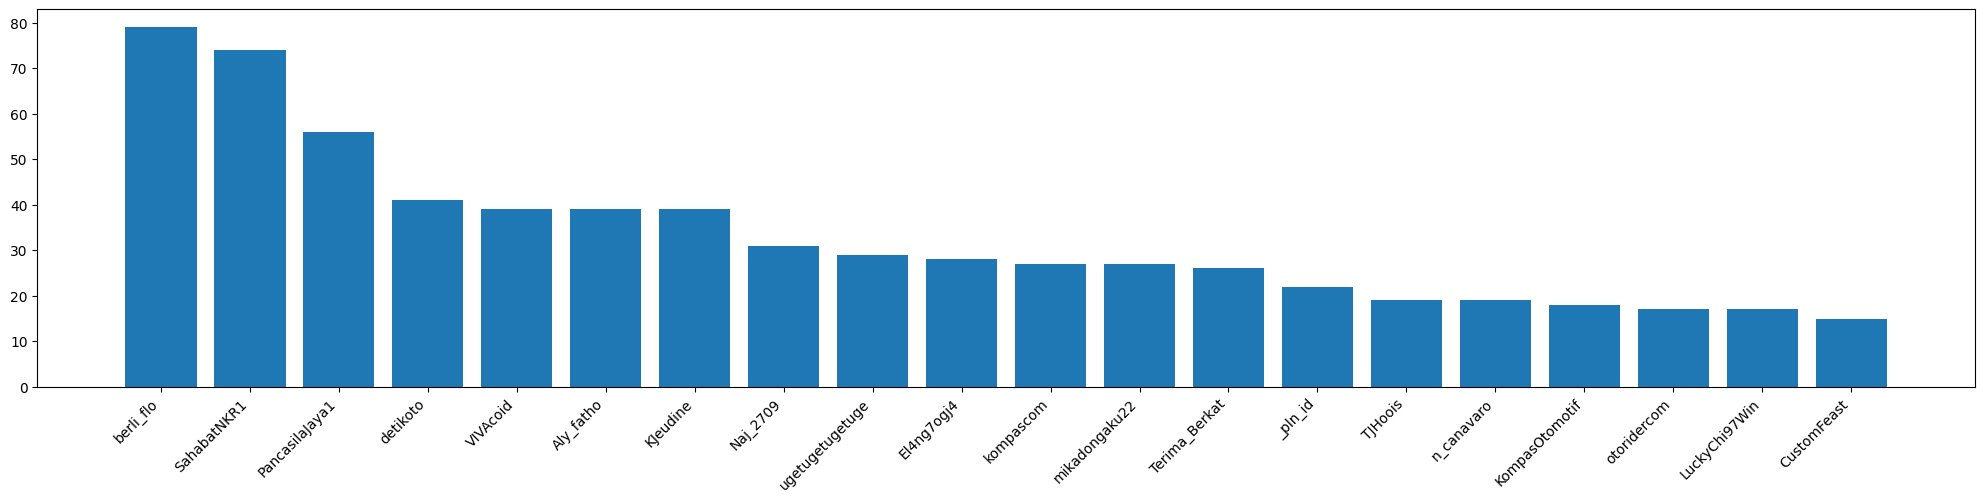

In [ ]:
#Top User
d = word_count(userdata)
sorted_d = dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True))

top_user = sorted_d.copy()
top_user = {k: top_user[k] for k in list(top_user)[:20]}

fig = plt.figure(figsize=(25,5),dpi=100)
ax = fig.add_subplot(111)
bar = ax.bar(range(len(top_user)), list(top_user.values()), align='center')
plt.xticks(range(len(top_user)), list(top_user.keys()))
plt.xticks(rotation=45, ha='right')
plt.savefig('top_user.png')
plt.show()

# Sentiment Analysis

Here we preprocess the data using sentiment analyzer below :

1.  TextBob and Vader
2.  Sahri
3.  Cardiff



In [ ]:
translator = Translator()
df_cleaned['trslt_text'] = df_cleaned['clean_text'].apply(translator.translate, dest='en').apply(getattr, args=('text',))

In [ ]:
df_cleaned_translated = df_cleaned.copy()
df_cleaned_translated ['clean_text'] = df_cleaned_translated ['clean_text'].astype(str)
df_cleaned_translated ['trslt_text'] = df_cleaned_translated ['trslt_text'].astype(str)
df_cleaned_translated = df_cleaned_translated.drop(columns = [ 'index'])

In [ ]:
df_cleaned_translated.head()

,Time,User,Tweet,is_verified_acc,clean_text,trslt_text
0,2022-07-21T23:45:16Z,nusakininews,Komitmen Konversi Seribu Sepeda Motor Penggera...,False,komitmen konversi ribu sepeda motor gerak bbm ...,Commitment to converting thousands of strong e...
1,2022-07-21T23:39:48Z,petrominer_com,Kementerian ESDM telah bekerjasama dengan beng...,False,menteri esdm bekerjasama bengkel bengkel usaha...,the minister of esdm cooperates with medium-si...
2,2022-07-21T23:39:19Z,prismono,Kementerian ESDM telah bekerjasama dengan beng...,False,menteri esdm bekerjasama bengkel bengkel usaha...,the minister of esdm cooperates with medium-si...
3,2022-07-21T23:10:22Z,iniayybeneran,Aaaa. Doi ngajak jalan. Tapi kata dia rahasia ...,False,aaaa doi ngajak jalan rahasia wkwkwk nnya mana...,"aaaa, doi ask for a secret path wkwkwk how do ..."
4,2022-07-21T18:27:09Z,icedcaffemisto,"sebagai pecinta ""sepeda cewek"", aku seneng ban...",False,cinta sepeda cewek neng banget sepeda listrik ...,I really love girls' bicycles. Electric bicycl...


## Text Blob and Vader

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values

for index, row in df_cleaned_translated["clean_text"].iteritems():
 score = SentimentIntensityAnalyzer().polarity_scores(row)
 neg = score["neg"]
 neu = score["neu"]
 pos = score["pos"]
 comp = score["compound"]
 if neg > pos:
   df_cleaned_translated.loc[index, "sentiment_textblob"] = "negative"
 elif pos > neg:
   df_cleaned_translated.loc[index, "sentiment_textblob"] = "positive"
 else:
   df_cleaned_translated.loc[index, "sentiment_textblob"] = "neutral"

## Sahri

In [ ]:
pretrained_name = "sahri/indonesiasentiment"

# tokenizer = AutoTokenizer.from_pretrained("sahri/sentiment")
# model = AutoModel.from_pretrained("sahri/sentiment")

nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)
def sentiment_analyzer(text):
  text = nlp(text)
  return text

df_cleaned_translated['sahri_indo'] = df_cleaned_translated['clean_text'].apply(sentiment_analyzer)
df_cleaned_translated['sahri_indo']= df_cleaned_translated['sahri_indo'].apply(pd.Series)
df_cleaned_translated[['sentiment_sahri', 'score']] = df_cleaned_translated['sahri_indo'].apply(pd.Series)
df_cleaned_translated = df_cleaned_translated.drop(columns = ['sahri_indo', 'score'])


## Cardiff

In [ ]:
pretrained_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
nlp= pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)
def sentiment_analyzer(text):
  text = nlp(text)
  return text

In [ ]:
df_cleaned_translated['cardiff_eng'] = df_cleaned_translated['trslt_text'].apply(sentiment_analyzer)
df_cleaned_translated['cardiff_eng']= df_cleaned_translated['cardiff_eng'].apply(pd.Series)
df_cleaned_translated[['sentiment_cardiff', 'score']] = df_cleaned_translated['cardiff_eng'].apply(pd.Series)
df_cleaned_translated = df_cleaned_translated.drop(columns = ['cardiff_eng', 'score'])

In [ ]:
# df_cleaned_translated.to_csv('/content/drive/MyDrive/02. Projects/01. Data Projects/Project Sentiment Analysis/Dataset/dataset_cleaned_translated_processed.csv')
df_ctp = df_cleaned_translated.copy()

In [ ]:
df_ctp.head()

,Time,User,Tweet,is_verified_acc,clean_text,trslt_text,sentiment_textblob,sentiment_sahri,sentiment_cardiff
0,2022-07-21T23:45:16Z,nusakininews,Komitmen Konversi Seribu Sepeda Motor Penggera...,False,komitmen konversi ribu sepeda motor gerak bbm ...,Commitment to converting thousands of strong e...,neutral,neutral,Positive
1,2022-07-21T23:39:48Z,petrominer_com,Kementerian ESDM telah bekerjasama dengan beng...,False,menteri esdm bekerjasama bengkel bengkel usaha...,the minister of esdm cooperates with medium-si...,neutral,neutral,Neutral
2,2022-07-21T23:39:19Z,prismono,Kementerian ESDM telah bekerjasama dengan beng...,False,menteri esdm bekerjasama bengkel bengkel usaha...,the minister of esdm cooperates with medium-si...,neutral,neutral,Neutral
3,2022-07-21T23:10:22Z,iniayybeneran,Aaaa. Doi ngajak jalan. Tapi kata dia rahasia ...,False,aaaa doi ngajak jalan rahasia wkwkwk nnya mana...,"aaaa, doi ask for a secret path wkwkwk how do ...",positive,negative,Negative
4,2022-07-21T18:27:09Z,icedcaffemisto,"sebagai pecinta ""sepeda cewek"", aku seneng ban...",False,cinta sepeda cewek neng banget sepeda listrik ...,I really love girls' bicycles. Electric bicycl...,neutral,positive,Positive


##Sentiment Distribution

From all sentiment analyzer, by comparing to our manual labeling. cardiff turns out to have the most similar sentiment to our manual labeling. so from here and so forth we will user cardiff as the sentiment analyzer

### Distribution in General

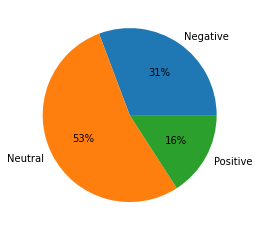

In [ ]:
viz_sentiment = df_ctp.groupby('sentiment_cardiff')['Tweet'].count()
viz_sentiment = viz_sentiment.reset_index()

#declaring exploding pie
explode = [0, 0.1, 0]
# define Seaborn color palette to use
palette_color = sns.color_palette('dark')
  
# plotting data on chart
plt.pie(viz_sentiment.Tweet, labels=viz_sentiment.sentiment_cardiff, autopct='%.0f%%')
  
# displaying chart
plt.show()

In [ ]:
viz_sentiment

,sentiment_cardiff,Tweet
0,Negative,1224
1,Neutral,2126
2,Positive,633


### Distribution from Official Account

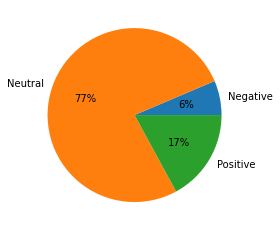

In [ ]:
df_temp = df_ctp[df_ctp['is_verified_acc'] == True]
viz_sentiment = df_temp.groupby('sentiment_cardiff')['Tweet'].count()
viz_sentiment = viz_sentiment.reset_index()

#declaring exploding pie
explode = [0, 0.1, 0]
# define Seaborn color palette to use
palette_color = sns.color_palette('dark')
  
# plotting data on chart
plt.pie(viz_sentiment.Tweet, labels=viz_sentiment.sentiment_cardiff, autopct='%.0f%%')
  
# displaying chart
plt.show()

In [ ]:
viz_sentiment

,sentiment_cardiff,Tweet
0,Negative,21
1,Neutral,251
2,Positive,56


### Distribution from Public Account

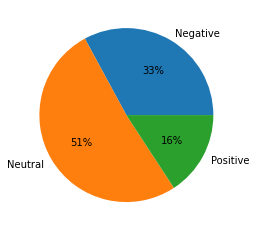

In [ ]:
df_temp = df_ctp[df_ctp['is_verified_acc'] == False]
viz_sentiment = df_temp.groupby('sentiment_cardiff')['Tweet'].count()
viz_sentiment = viz_sentiment.reset_index()

#declaring exploding pie
explode = [0, 0.1, 0]
# define Seaborn color palette to use
palette_color = sns.color_palette('dark')
  
# plotting data on chart
plt.pie(viz_sentiment.Tweet, labels=viz_sentiment.sentiment_cardiff, autopct='%.0f%%')
  
# displaying chart
plt.show()

In [ ]:
viz_sentiment

,sentiment_cardiff,Tweet
0,Negative,1203
1,Neutral,1875
2,Positive,577


# Most Trending Topic

## Topic in General

In [ ]:
df_ctp = df_ctp.dropna()

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
datafinal = df_ctp.clean_text.values.tolist()
data_words = list(sent_to_words(datafinal))

In [ ]:
bigram = Phrases(data_words, min_count=10) #only took data with [min_count] minimum appearance
trigram = Phrases(bigram[data_words])
for idx in range(len(data_words)):
    for token in bigram[data_words[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data_words[idx].append(token)
    for token in trigram[data_words[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data_words[idx].append(token)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

id2word.filter_extremes(no_below=5, no_above=0.2) #no_below : min_appearance, no_above : max_appearance from all corpus
print(id2word)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
#The function doc2bow converts document (a list of words) into the bag-of-words format

Dictionary(2094 unique tokens: ['bbm', 'gerak', 'komitmen', 'konversi', 'kuat']...)


In [ ]:
tfidf = models.TfidfModel(corpus) #build TF-IDF model
corpus_tfidf = tfidf[corpus]

In [ ]:
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(n

In [ ]:
import pyLDAvis.gensim_models;pyLDAvis.enable_notebook()
dt = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word)

lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
vectorizer = TfidfVectorizer(min_df=3, max_features = 10000)
vz = vectorizer.fit_transform(datafinal)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

num_clusters = 3
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, init_size=1000, batch_size=1000, verbose=False, max_iter=1000, random_state = 101)
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    for j in sorted_centroids[i, :5]:
        print(' %s' % terms[j])
    print()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Cluster 0:
 kendara
 moeldoko
 pln
 listrik
 perban

Cluster 1:
 larang
 ngebulnya
 fortuner
 ngebut
 diesel

Cluster 2:
 mobil
 listrik
 motor
 sepeda
 harga



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



##Topic From Positive Sentiment

In [ ]:
datapositive = df_ctp[df_ctp['sentiment_cardiff']== 'Positive'].clean_text.values.tolist()
data_words = list(sent_to_words(datafinal))

In [ ]:
bigram = Phrases(data_words, min_count=10) #only took data with [min_count] minimum appearance
trigram = Phrases(bigram[data_words])
for idx in range(len(data_words)):
    for token in bigram[data_words[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data_words[idx].append(token)
    for token in trigram[data_words[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data_words[idx].append(token)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

id2word.filter_extremes(no_below=5, no_above=0.2) #no_below : min_appearance, no_above : max_appearance from all corpus
print(id2word)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
#The function doc2bow converts document (a list of words) into the bag-of-words format

Dictionary(2094 unique tokens: ['bbm', 'gerak', 'komitmen', 'konversi', 'kuat']...)


In [ ]:
tfidf = models.TfidfModel(corpus) #build TF-IDF model
corpus_tfidf = tfidf[corpus]

In [ ]:
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(n

In [ ]:
import pyLDAvis.gensim_models;pyLDAvis.enable_notebook()
dt = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word)

lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
vectorizer = TfidfVectorizer(min_df=4, max_features = 10000)
vzpositive = vectorizer.fit_transform(datapositive)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

num_clusters = 3
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, random_state = 101)
kmeans = kmeans_model.fit(vzpositive)
kmeans_clusters = kmeans.predict(vzpositive)
kmeans_distances = kmeans.transform(vzpositive)
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    for j in sorted_centroids[i, :5]:
        print(' %s' % terms[j])
    print()

Cluster 0:
 mobil
 listrik
 motor
 sepeda
 face

Cluster 1:
 kendara
 pln
 moeldoko
 komitmen
 kepala

Cluster 2:
 moeldoko
 dorong
 indonesia
 penjagankri
 tumbuh



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



##Topic From Negative Sentiment

In [ ]:
datanegative = df_ctp[df_ctp['sentiment_cardiff']== 'Negative'].clean_text.values.tolist()
data_words = list(sent_to_words(datafinal))

In [ ]:
bigram = Phrases(data_words, min_count=10) #only took data with [min_count] minimum appearance
trigram = Phrases(bigram[data_words])
for idx in range(len(data_words)):
    for token in bigram[data_words[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data_words[idx].append(token)
    for token in trigram[data_words[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data_words[idx].append(token)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

id2word.filter_extremes(no_below=5, no_above=0.2) #no_below : min_appearance, no_above : max_appearance from all corpus
print(id2word)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
#The function doc2bow converts document (a list of words) into the bag-of-words format

Dictionary(2094 unique tokens: ['bbm', 'gerak', 'komitmen', 'konversi', 'kuat']...)


In [ ]:
tfidf = models.TfidfModel(corpus) #build TF-IDF model
corpus_tfidf = tfidf[corpus]

In [ ]:
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(n

In [ ]:
import pyLDAvis.gensim_models;pyLDAvis.enable_notebook()
dt = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word)

lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
vectorizer = TfidfVectorizer(min_df=4, max_features = 10000)
vznegative = vectorizer.fit_transform(datanegative)
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

num_clusters = 3
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, random_state = 101)
kmeans = kmeans_model.fit(vznegative)
kmeans_clusters = kmeans.predict(vznegative)
kmeans_distances = kmeans.transform(vznegative)
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    for j in sorted_centroids[i, :5]:
        print(' %s' % terms[j])
    print()

Cluster 0:
 mobil
 lis
 gile
 infrastruktur
 massif

Cluster 1:
 larang
 listrik
 ngebulnya
 fortuner
 ngebut

Cluster 2:
 mobil
 listrik
 moeldoko
 kendara
 motor



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

